&copy; Michael Daniel 2018
# Fit Linke Turbidity Factor 
## to Bayesian block change points of irradiance measurement time series

Tested with
* JupyterLab v3.2.4
* pandas v1.3.4
* matplotlib v3.5.1
* numpy v1.23.0
* sciy v1.8.1
* pvlib v0.9.1

Assumes that sunrise/set times have already been calculated for the days and saved to a text file of "Date sunrise sunset" in format 'YYYY-MM-DD HH:MM:SS HH:MM:SS', e.g.

* `2018-01-01 08:17:04 16:00:11`

I use Skyfield for generating this.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pytz import timezone
from pvlib.location import Location
import pvlib.clearsky

some general housekeeping

In [2]:
tz = timezone('UTC')
lat = 52.7616
lon = -1.2406 # +ve East from Greenwich Meridian
location = Location(lat, lon, name="Loughborough", altitude=79, tz=tz)

lt_min=1
lt_max=7

#prefix = "../Data"
prefix = "./Data"
YEAR=2018
#datadir = "D:Data/Lboro"
datadir = f"{prefix}"
cols = ['MTR TimeStamp', 'GHI [W/m2]']


the routines, `bayesian_blocks` is same as in BayesianBlocks_v2.ipynb

In [3]:
# following https://docs.astropy.org/en/stable/_modules/astropy/stats/bayesian_blocks.html#bayesian_blocks
import warnings

import numpy as np

from inspect import signature

__all__ = ['FitnessFunc', 'PointMeasures',
           'bayesian_blocks']
def bayesian_blocks(t, x=None, sigma=None,
                    fitness='events', **kwargs):
    r"""Compute optimal segmentation of data with Scargle's Bayesian Blocks

    This is a flexible implementation of the Bayesian Blocks algorithm
    described in Scargle 2013 [1]_.

    Parameters
    ----------
    t : array-like
        data times (one dimensional, length N)
    x : array-like, optional
        data values
    sigma : array-like or float, optional
        data errors
    fitness : str or object
        the fitness function to use for the model.
        If a string, the following options are supported:

        - nb, not used here 'events' : binned or unbinned event data.  Arguments are ``gamma``,
          which gives the slope of the prior on the number of bins, or
          ``ncp_prior``, which is :math:`-\ln({\tt gamma})`.
        - nb, not used here 'regular_events' : non-overlapping events measured at multiples of a
          fundamental tick rate, ``dt``, which must be specified as an
          additional argument.  Extra arguments are ``p0``, which gives the
          false alarm probability to compute the prior, or ``gamma``, which
          gives the slope of the prior on the number of bins, or ``ncp_prior``,
          which is :math:`-\ln({\tt gamma})`.
        - 'measures' : fitness for a measured sequence with Gaussian errors.
          Extra arguments are ``p0``, which gives the false alarm probability
          to compute the prior, or ``gamma``, which gives the slope of the
          prior on the number of bins, or ``ncp_prior``, which is
          :math:`-\ln({\tt gamma})`.

        In all three cases, if more than one of ``p0``, ``gamma``, and
        ``ncp_prior`` is chosen, ``ncp_prior`` takes precedence over ``gamma``
        which takes precedence over ``p0``.

        Alternatively, the fitness parameter can be an instance of
        :class:`FitnessFunc` or a subclass thereof.

    **kwargs :
        any additional keyword arguments will be passed to the specified
        :class:`FitnessFunc` derived class.

    Returns
    -------
    edges : ndarray
        array containing the (N+1) edges defining the N bins

    Examples
    --------

    .. testsetup::

        >>> np.random.seed(12345)

    Measured point data with errors:

    >>> t = 100 * np.random.random(100)
    >>> x = np.exp(-0.5 * (t - 50) ** 2)
    >>> sigma = 0.1
    >>> x_obs = np.random.normal(x, sigma)
    >>> edges = bayesian_blocks(t, x_obs, sigma, fitness='measures')

    References
    ----------
    .. [1] Scargle, J et al. (2013)
       https://ui.adsabs.harvard.edu/abs/2013ApJ...764..167S

    .. [2] Bellman, R.E., Dreyfus, S.E., 1962. Applied Dynamic
       Programming. Princeton University Press, Princeton.
       https://press.princeton.edu/books/hardcover/9780691651873/applied-dynamic-programming

    .. [3] Bellman, R., Roth, R., 1969. Curve fitting by segmented
       straight lines. J. Amer. Statist. Assoc. 64, 1079–1084.
       https://www.tandfonline.com/doi/abs/10.1080/01621459.1969.10501038

    See Also
    --------
    astropy.stats.histogram : compute a histogram using bayesian blocks
    """
    #FITNESS_DICT = {'events': Events,
    #                'regular_events': RegularEvents,
    #                'measures': PointMeasures}
    FITNESS_DICT = {'measures': PointMeasures}
    fitness = FITNESS_DICT.get(fitness, fitness)

    if type(fitness) is type and issubclass(fitness, FitnessFunc):
        fitfunc = fitness(**kwargs)
    elif isinstance(fitness, FitnessFunc):
        fitfunc = fitness
    else:
        raise ValueError("fitness parameter not understood")

    return fitfunc.fit(t, x, sigma)

class FitnessFunc:
    """Base class for bayesian blocks fitness functions

    Derived classes should overload the following method:

    ``fitness(self, **kwargs)``:
      Compute the fitness given a set of named arguments.
      Arguments accepted by fitness must be among ``[T_k, N_k, a_k, b_k, c_k]``
      (See [1]_ for details on the meaning of these parameters).

    Additionally, other methods may be overloaded as well:

    ``__init__(self, **kwargs)``:
      Initialize the fitness function with any parameters beyond the normal
      ``p0`` and ``gamma``.

    ``validate_input(self, t, x, sigma)``:
      Enable specific checks of the input data (``t``, ``x``, ``sigma``)
      to be performed prior to the fit.

    ``compute_ncp_prior(self, N)``: If ``ncp_prior`` is not defined explicitly,
      this function is called in order to define it before fitting. This may be
      calculated from ``gamma``, ``p0``, or whatever method you choose.

    ``p0_prior(self, N)``:
      Specify the form of the prior given the false-alarm probability ``p0``
      (See [1]_ for details).

    For examples of implemented fitness functions, see :class:`Events`,
    :class:`RegularEvents`, and :class:`PointMeasures`.

    References
    ----------
    .. [1] Scargle, J et al. (2013)
       https://ui.adsabs.harvard.edu/abs/2013ApJ...764..167S
    """
    def __init__(self, p0=0.05, gamma=None, ncp_prior=None):
        self.p0 = p0
        self.gamma = gamma
        self.ncp_prior = ncp_prior

    def validate_input(self, t, x=None, sigma=None):
        """Validate inputs to the model.

        Parameters
        ----------
        t : array-like
            times of observations
        x : array-like, optional
            values observed at each time
        sigma : float or array-like, optional
            errors in values x

        Returns
        -------
        t, x, sigma : array-like, float or None
            validated and perhaps modified versions of inputs
        """
        # validate array input
        t = np.asarray(t, dtype=float)

        # find unique values of t
        t = np.array(t)
        if t.ndim != 1:
            raise ValueError("t must be a one-dimensional array")
        unq_t, unq_ind, unq_inv = np.unique(t, return_index=True,
                                            return_inverse=True)

        # if x is not specified, x will be counts at each time
        if x is None:
            if sigma is not None:
                raise ValueError("If sigma is specified, x must be specified")
            else:
                sigma = 1

            if len(unq_t) == len(t):
                x = np.ones_like(t)
            else:
                x = np.bincount(unq_inv)

            t = unq_t

        # if x is specified, then we need to simultaneously sort t and x
        else:
            # TODO: allow broadcasted x?
            x = np.asarray(x, dtype=float)

            if x.shape not in [(), (1,), (t.size,)]:
                raise ValueError("x does not match shape of t")
            x += np.zeros_like(t)

            if len(unq_t) != len(t):
                raise ValueError("Repeated values in t not supported when "
                                 "x is specified")
            t = unq_t
            x = x[unq_ind]

        # verify the given sigma value
        if sigma is None:
            sigma = 1
        else:
            sigma = np.asarray(sigma, dtype=float)
            if sigma.shape not in [(), (1,), (t.size,)]:
                raise ValueError('sigma does not match the shape of x')

        return t, x, sigma

    def fitness(self, **kwargs):
        raise NotImplementedError()

    def p0_prior(self, N):
        """
        Empirical prior, parametrized by the false alarm probability ``p0``
        See  eq. 21 in Scargle (2013)

        Note that there was an error in this equation in the original Scargle
        paper (the "log" was missing). The following corrected form is taken
        from https://arxiv.org/abs/1304.2818
        """
        return 4 - np.log(73.53 * self.p0 * (N ** -0.478))

    # the fitness_args property will return the list of arguments accepted by
    # the method fitness().  This allows more efficient computation below.
    @property
    def _fitness_args(self):
        return signature(self.fitness).parameters.keys()

    def compute_ncp_prior(self, N):
        """
        If ``ncp_prior`` is not explicitly defined, compute it from ``gamma``
        or ``p0``.
        """

        if self.gamma is not None:
            return -np.log(self.gamma)
        elif self.p0 is not None:
            return self.p0_prior(N)
        else:
            raise ValueError("``ncp_prior`` cannot be computed as neither "
                             "``gamma`` nor ``p0`` is defined.")

    def fit(self, t, x=None, sigma=None):
        """Fit the Bayesian Blocks model given the specified fitness function.

        Parameters
        ----------
        t : array-like
            data times (one dimensional, length N)
        x : array-like, optional
            data values
        sigma : array-like or float, optional
            data errors

        Returns
        -------
        edges : ndarray
            array containing the (M+1) edges defining the M optimal bins
        """
        t, x, sigma = self.validate_input(t, x, sigma)

        # compute values needed for computation, below
        if 'a_k' in self._fitness_args:
            ak_raw = np.ones_like(x) / sigma ** 2
        if 'b_k' in self._fitness_args:
            bk_raw = x / sigma ** 2
        if 'c_k' in self._fitness_args:
            ck_raw = x * x / sigma ** 2

        # create length-(N + 1) array of cell edges
        edges = np.concatenate([t[:1],
                                0.5 * (t[1:] + t[:-1]),
                                t[-1:]])
        block_length = t[-1] - edges

        # arrays to store the best configuration
        N = len(t)
        best = np.zeros(N, dtype=float)
        last = np.zeros(N, dtype=int)

        # Compute ncp_prior if not defined
        if self.ncp_prior is None:
            ncp_prior = self.compute_ncp_prior(N)
        else:
            ncp_prior = self.ncp_prior

        # ----------------------------------------------------------------
        # Start with first data cell; add one cell at each iteration
        # ----------------------------------------------------------------
        for R in range(N):
            # Compute fit_vec : fitness of putative last block (end at R)
            kwds = {}

            # T_k: width/duration of each block
            if 'T_k' in self._fitness_args:
                kwds['T_k'] = block_length[:R + 1] - block_length[R + 1]

            # N_k: number of elements in each block
            if 'N_k' in self._fitness_args:
                kwds['N_k'] = np.cumsum(x[:R + 1][::-1])[::-1]

            # a_k: eq. 31
            if 'a_k' in self._fitness_args:
                kwds['a_k'] = 0.5 * np.cumsum(ak_raw[:R + 1][::-1])[::-1]

            # b_k: eq. 32
            if 'b_k' in self._fitness_args:
                kwds['b_k'] = - np.cumsum(bk_raw[:R + 1][::-1])[::-1]

            # c_k: eq. 33
            if 'c_k' in self._fitness_args:
                kwds['c_k'] = 0.5 * np.cumsum(ck_raw[:R + 1][::-1])[::-1]

            # evaluate fitness function
            fit_vec = self.fitness(**kwds)

            A_R = fit_vec - ncp_prior
            A_R[1:] += best[:R]

            i_max = np.argmax(A_R)
            last[R] = i_max
            best[R] = A_R[i_max]

        # ----------------------------------------------------------------
        # Now find changepoints by iteratively peeling off the last block
        # ----------------------------------------------------------------
        change_points = np.zeros(N, dtype=int)
        i_cp = N
        ind = N
        while i_cp > 0:
            i_cp -= 1
            change_points[i_cp] = ind
            if ind == 0:
                break
            ind = last[ind - 1]
        if i_cp == 0:
            change_points[i_cp] = 0
        change_points = change_points[i_cp:]

        return edges[change_points]

class PointMeasures(FitnessFunc):
    r"""Bayesian blocks fitness for point measures

    Parameters
    ----------
    p0 : float, optional
        False alarm probability, used to compute the prior on :math:`N_{\rm
        blocks}` (see eq. 21 of Scargle 2013). If gamma is specified, p0 is
        ignored.
    ncp_prior : float, optional
        If specified, use the value of ``ncp_prior`` to compute the prior as
        above, using the definition :math:`{\tt ncp\_prior} = -\ln({\tt
        gamma})`.  If ``ncp_prior`` is specified, ``gamma`` and ``p0`` are
        ignored.
    """
    def __init__(self, p0=0.05, gamma=None, ncp_prior=None):
        super().__init__(p0, gamma, ncp_prior)

    def fitness(self, a_k, b_k):
        # eq. 41 from Scargle 2013
        return (b_k * b_k) / (4 * a_k)

    def validate_input(self, t, x, sigma):
        if x is None:
            raise ValueError("x must be specified for point measures")
        return super().validate_input(t, x, sigma)


At minimum
```
date = '2018-06-26'
obs = getOBS(date)
def = getCDA(obs)
t = np.array(obs.index.to_frame(index=None).index.to_series().values)
obs_edges = bayesian_blocks(t, obs['GHI [W/m2]'], sigma, fitness='measures', p0=p0)
obs_cp = len(obs_edges)
print(obs_cp)
cp = []
for lt in range(lt_min,lt_max+1):
    cs = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=lt)
    edges = bayesian_blocks(t, cs['ghi'], sigma, fitness='measures', p0=p0)
    cp.append(len(edges))

   ...

ydata = range(lt_min,lt_max+1)
popt, pcov = curve_fit(func, cp, ydata)
obs_lt = func(obs_cp, *popt)
print(obs_cp, obs_lt)

```

In [7]:
## if don't care about sunrise/set issues
#def getOBS(date, verbose=False):
#    #cols = ['MTR TimeStamp', 'GHI [W/m2]', 'DHI [W/m2]', 'BNI [W/m2]']
#    cols = ['MTR TimeStamp', 'GHI [W/m2]']
#    indir = "D:Data/Lboro"
#    obs = pd.read_csv(f"{indir}/{date}.csv", sep=',', index_col=0, header='infer', parse_dates=True, usecols=cols)
#    if verbose:
#        print(obs.info())
#    return obs
## if do
suntimes = pd.read_csv(f'{prefix}/{YEAR}-SunRiseSetTimes.txt', index_col=0, sep=' ', header=None, names=['date', 'rise', 'set'], parse_dates=True)
print(suntimes.info())

def getOBS(date, hours=0, verbose=False):
    '''get a Pandas DataFrame of the pyranometer measurements

    Parameters
    ----------
    date - string in "YYYY-MM-DD" format
    hours - if you want to leave a grace period around sunrise/set when pyranometer readings are close to 0 (def. 0)
    verbose - how chatty the routine is so you can trace that its working (def. false)
    
    Returns
    -------
    obs - pandas dataframe of the pyranometer measurements with times between sunrise+hours and sunset-hours
    '''
    obs = pd.read_csv(f"{datadir}/{date}.csv", sep=',', index_col=0, header='infer', parse_dates=True, usecols=cols)
    if verbose:
        print(obs.info())

    sunrise,sunset = suntimes.iloc[suntimes.index.get_loc(date)]
    #print(date, sunrise, sunset)
    sunrise = datetime.strptime(f"{date} {sunrise}", "%Y-%m-%d %H:%M:%S")
    sunset = datetime.strptime(f"{date} {sunset}", "%Y-%m-%d %H:%M:%S")
    print("\t", sunrise, sunset, sunset-sunrise)
    start = sunrise+timedelta(hours=hours)
    end = sunset-timedelta(hours=hours)

    return obs.between_time(start_time=start.time().isoformat(), end_time=end.time().isoformat())

def getCDA(obs, t=None):
    '''return a pvlib clear sky model for the given pyranometer measurement times

    Parameters
    ----------
    obs - pandas DataFrame of the pyranometer measurements
    t - Linke Turbidity Factor (def. pvlib default)

    Returns
    -------
    cs - pvlib dataframe of 'ghi', 'dhi', 'bni' for the timeseries
    '''
    if t:
        return location.get_clearsky(obs.index, model='ineichen', linke_turbidity=t)
    else:
        return location.get_clearsky(obs.index, model='ineichen')

def date_parser(date_string):
    fmt="%Y%m%d:%H%M"
    return datetime.strptime(date_string, fmt)

def readPVGIS(file="Timeseries_52.762_-1.241_SA2_0deg_-179deg_2018_2018.csv", prefix=prefix):
    # let us hope it isn't a leap year...
    df = pd.read_csv(f"{prefix}/{file}", sep=',', index_col=0, skiprows=8, nrows=8760, header='infer', parse_dates=True, date_parser=date_parser)
    return df


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-01 to 2018-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rise    365 non-null    object
 1   set     365 non-null    object
dtypes: object(2)
memory usage: 8.6+ KB
None


# Example for a single day
* with PVGIS
* with threshold bounds plotted

In [9]:
sigma = 25
p0=0.01

YEAR=2018
date = "2018-06-26"
t_pvgis=2.1
PVGIS = readPVGIS()
hours=1

times = pd.read_csv(f'{prefix}/{YEAR}-SunRiseSetTimes.txt', index_col=0, sep=' ', header=None, names=['date', 'rise', 'set'], parse_dates=True)
print(times.info())

sunrise,sunset = times.iloc[times.index.get_loc(date)]
#print(date, sunrise, sunset)
sunrise = datetime.strptime(f"{date} {sunrise}", "%Y-%m-%d %H:%M:%S")
sunset = datetime.strptime(f"{date} {sunset}", "%Y-%m-%d %H:%M:%S")
print(date, sunrise, sunset, sunset-sunrise)
#start = sunrise + timedelta(hours=0.5)
#end = sunset - timedelta(hours=0.5)
start = sunrise
#end = sunset
end = sunrise + timedelta(hours=hours)
start = start.time().isoformat() # auto is seconds %H:%M:%S format string\n",
end = end.time().isoformat()
print(start, end)

obs = getOBS(date)
obs_clip = obs.between_time(start_time=start, end_time=end)
t = np.array(obs.index.to_frame(index=None).index.to_series().values)

obs_edges = bayesian_blocks(t, obs['GHI [W/m2]'], sigma, fitness='measures', p0=p0)
obs_cp = len(obs_edges)
print(obs_cp)
cp = []
for lt in range(lt_min,lt_max+1):
    cs = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=lt)
    edges = bayesian_blocks(t, cs['ghi'], sigma, fitness='measures', p0=p0)
    cp.append(len(edges))
    print(f"{lt}, {len(edges)}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-01 to 2018-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rise    365 non-null    object
 1   set     365 non-null    object
dtypes: object(2)
memory usage: 8.6+ KB
None
2018-06-26 2018-06-26 03:41:54 2018-06-26 20:33:33 16:51:39
03:41:54 04:41:54
	 2018-06-26 03:41:54 2018-06-26 20:33:33 16:51:39
5


C:\Users\mkdan\.conda\envs\crest\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(*inputs, **kwargs)


1, 9
2, 7
3, 6
4, 5
5, 4
6, 4
7, 3


In [14]:
obs = getOBS(date)


	 2018-06-26 03:41:54 2018-06-26 20:33:33 16:51:39


5 4.076190476481438


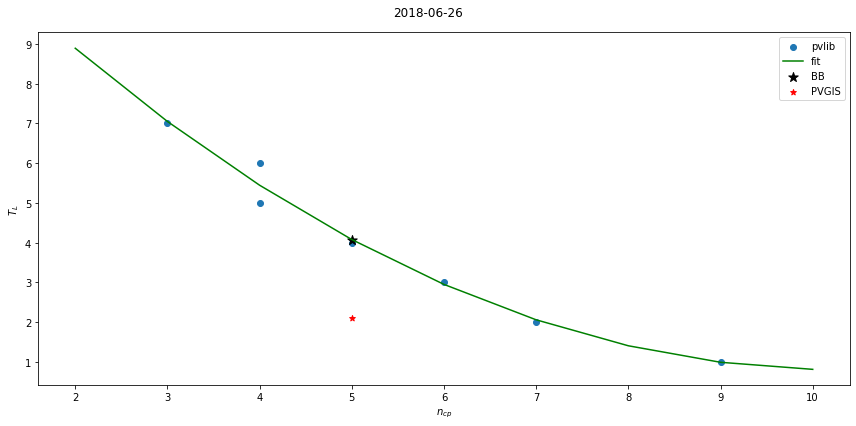

In [10]:
from scipy.optimize import curve_fit

#def func(x, m,c):
#    return m*x + c

def func(x, a,b,c):
    return a*x*x +b*x + c

ydata = range(lt_min,lt_max+1)
popt, pcov = curve_fit(func, cp, ydata)
obs_lt = func(obs_cp, *popt)
print(obs_cp, obs_lt)

ncols=1
nrows=1
fig,axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12*ncols,6*nrows))
fig.suptitle(date)
ax=axs
ax.set_xlabel("$n_{cp}$")
ax.set_ylabel("$T_L$")

cp = np.array(cp)
#cols=['date', 'ghi (obs)', 'ghi (sim)', 'dhi (obs)', 'dhi (sim)']
#prefix=f"D:/Data/Lboro/Blocks-sigma-{sigma:.2f}"
#df = pd.read_csv(f"{prefix}/2018-ind-blocks-results.txt", sep='\t', index_col=0, names=cols, parse_dates=True)
#print(df.info())
#turbidity = pvlib.clearsky.lookup_linke_turbidity(df.index, latitude=lat, longitude=lon)

ax.scatter(cp, ydata, label='pvlib') # the fit points
xdata = np.arange(cp.min()-1,cp.max()+2)
ax.plot(xdata, func(xdata, *popt), 'g-', label='fit') # the fit line
ax.scatter(obs_cp, obs_lt, marker="*", s=100, label='BB', color='black')
ax.scatter(obs_cp, t_pvgis, marker="*", label='PVGIS', color='r')
#i = df.index.get_loc(date)
#print(i, df.index[i])
#print(i, df.index[i], df['ghi (obs)'].iloc[i], df['ghi (sim)'].iloc[i], func(df['ghi (obs)'].iloc[i], *popt))
#ax.scatter(df['ghi (obs)'].iloc[i], turbidity.iloc[i], marker="*", label='PVGIS', color='r')
#ax.scatter(df['ghi (obs)'].iloc[i], func(df['ghi (obs)'].iloc[i], *popt), marker="*", s=100, label='BB', color='black')
ax.legend(loc='best')

plt.tight_layout()
#plt.savefig(f"TurbidityFit-{date}-{sigma:.2f}.png", facecolor='w')

C:\Users\mkdan\.conda\envs\crest\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mkdan\.conda\envs\crest\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mkdan\.conda\envs\crest\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mkdan\.conda\envs\crest\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(*inputs, **kwargs)


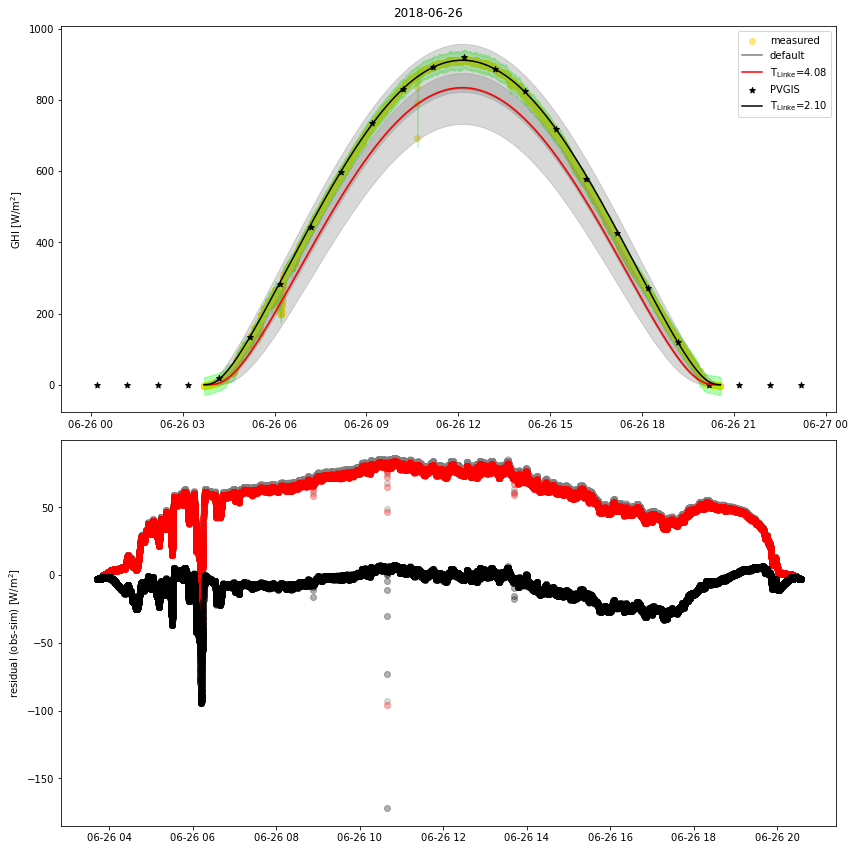

In [15]:
# make a pretty picture
ncols=1
nrows=2
fig,axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12*ncols,6*nrows))
fig.suptitle(f"{date}")

ax = axs[0]
ax.set_ylabel("GHI [W/m$^2$]")
ax.scatter(obs.index, obs['GHI [W/m2]'], label='measured', alpha=0.5, color='gold')
ax.fill_between(x=obs.index, y1=obs['GHI [W/m2]']-sigma, y2=obs['GHI [W/m2]']+sigma, alpha=0.3, color='lime')

# from completely clear and dry to full on industrial
best = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=1)
worst = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=7)
ax.fill_between(best.index, y1=worst['ghi'], y2=best['ghi'], color='grey', alpha=0.3)
# from pvlib satellite values for the location
best = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=3)
worst = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=4.4)
ax.fill_between(best.index, y1=worst['ghi'], y2=best['ghi'], color='grey', alpha=0.3)

default = location.get_clearsky(obs.index, model='ineichen')
t = func(obs_cp, *popt)
better = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=obs_lt)
ax.plot(default.index, default['ghi'], label='default', color='grey')
ax.plot(better.index, better['ghi'], label=f'T$_\mathrm{{Linke}}$={obs_lt:.2f}', color='r')
doy=obs.index[0].dayofyear-1
ax.scatter(PVGIS.index[doy*24:doy*24+24], PVGIS['Gb(i)'][doy*24:doy*24+24]+PVGIS['Gd(i)'][doy*24:doy*24+24]+PVGIS['Gr(i)'][doy*24:doy*24+24], marker="*", color='k', label='PVGIS')
pvgis = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=t_pvgis)
ax.plot(pvgis.index, pvgis['ghi'], label=f'T$_\mathrm{{Linke}}$={t_pvgis:.2f}', color='k')
ax.legend(loc="best")

ax=axs[1]
ax.set_ylabel("residual (obs-sim) [W/m$^2$]")
ax.scatter(obs.index, obs['GHI [W/m2]']-default['ghi'], label='cf default', alpha=0.3, color='grey')
#t = func(obs_cp, *popt)
ax.scatter(obs.index, obs['GHI [W/m2]']-better['ghi'], label=f'cf T$_\mathrm{{Linke}}$={t:.2f}', alpha=0.3, color='r')
ax.scatter(obs.index, obs['GHI [W/m2]']-pvgis['ghi'], label=f'cf PVGIS T$_\mathrm{{Linke}}$={t_pvgis:.2f}', alpha=0.3, color='k')

plt.tight_layout()
plt.savefig(f"FitTurbBB-{date}-sigma-{sigma:.2f}.png", facecolor='w')

# Example for a single day
## with PVGIS

In [16]:
# load pyranometer measurements
date = "2018-06-26"
obs = getOBS(date)

	 2018-06-26 03:41:54 2018-06-26 20:33:33 16:51:39


In [18]:
# calculate change points
YEAR=2018
sigma = 25
p0=0.01
t_pvgis=2.1

times = pd.read_csv(f'{prefix}/{YEAR}-SunRiseSetTimes.txt', index_col=0, sep=' ', header=None, names=['date', 'rise', 'set'], parse_dates=True)
print(times.info())

sunrise,sunset = times.iloc[times.index.get_loc(date)]
#print(date, sunrise, sunset)
sunrise = datetime.strptime(f"{date} {sunrise}", "%Y-%m-%d %H:%M:%S")
sunset = datetime.strptime(f"{date} {sunset}", "%Y-%m-%d %H:%M:%S")
print(date, sunrise, sunset, sunset-sunrise)
start = sunrise
hours = 3
end = sunrise + timedelta(hours=hours)
start = start.time().isoformat() # auto is seconds %H:%M:%S format string\n",
end = end.time().isoformat()
print(start, end)

obs_clip = getOBS(date).between_time(start_time=start, end_time=end)

t = np.array(obs_clip.index.to_frame(index=None).index.to_series().values)
obs_edges = bayesian_blocks(t, obs_clip['GHI [W/m2]'], sigma, fitness='measures', p0=p0)
cp_obs = len(obs_edges)
print(cp_obs)

cp = []
for lt in range(lt_min,lt_max+1):
    cs = location.get_clearsky(obs_clip.index, model='ineichen', linke_turbidity=lt)
    #t = np.array(cs.index.to_frame(index=None).index.to_series().values)
    edges = bayesian_blocks(t, cs['ghi'], sigma, fitness='measures', p0=p0)
    cp.append(len(edges))
    print(f"{lt}, {len(edges)}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-01 to 2018-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rise    365 non-null    object
 1   set     365 non-null    object
dtypes: object(2)
memory usage: 8.6+ KB
None
2018-06-26 2018-06-26 03:41:54 2018-06-26 20:33:33 16:51:39
03:41:54 06:41:54
	 2018-06-26 03:41:54 2018-06-26 20:33:33 16:51:39
27


C:\Users\mkdan\.conda\envs\crest\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(*inputs, **kwargs)


1, 31
2, 29
3, 27
4, 25
5, 23
6, 22
7, 20


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-01 to 2018-12-31
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ghi (obs)  365 non-null    int64
 1   ghi (sim)  365 non-null    int64
 2   dhi (obs)  365 non-null    int64
 3   dhi (sim)  365 non-null    int64
dtypes: int64(4)
memory usage: 14.3 KB
None
176 2018-06-26 00:00:00 2.963311550420677


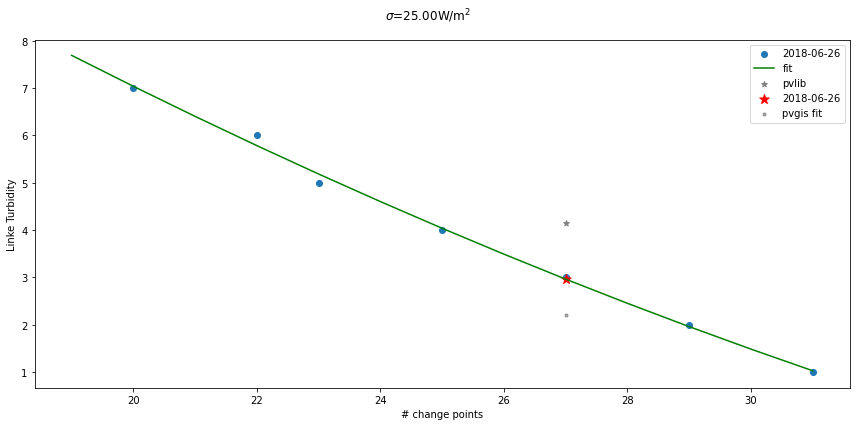

In [19]:
# fit change points and find the best fit Linke turbidity factor
from scipy.optimize import curve_fit

#def func(x, m,c):
#    return m*x + c
def func(x, a,b,c):
    return a*x**2 + b*x + c

ydata = range(lt_min,lt_max+1)
popt, pcov = curve_fit(func, cp, ydata)

ncols=1
nrows=1
fig,axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12*ncols,6*nrows))
fig.suptitle(f"$\sigma$={sigma:.2f}W/m$^2$")
ax=axs

cp = np.array(cp)
cols=['date', 'ghi (obs)', 'ghi (sim)', 'dhi (obs)', 'dhi (sim)']
prefix=f"../Data/Blocks-sigma-{sigma:.2f}"
prefix=f"D:/Data/Lboro/Blocks-sigma-{sigma:.2f}"
df = pd.read_csv(f"{prefix}/2018-ind-blocks-results.txt", sep='\t', index_col=0, names=cols, parse_dates=True)
print(df.info())
turbidity = pvlib.clearsky.lookup_linke_turbidity(df.index, latitude=lat, longitude=lon)
ax.set_xlabel('# change points')
ax.set_ylabel('Linke Turbidity')
ax.scatter(cp, ydata, label=date)
xdata = np.arange(cp.min()-1,cp.max()+1)
ax.plot(xdata, func(xdata, *popt), 'g-', label='fit')
i = df.index.get_loc(date)
#print(i, df.index[i])
print(i, df.index[i], func(cp_obs, *popt))
ax.scatter(cp_obs, turbidity.iloc[i], marker="*", label="pvlib", color='grey')
ax.scatter(cp_obs, func(cp_obs, *popt), marker="*", s=100, label=date, color='r')
ax.scatter(cp_obs, 2.2, marker="o", s=10, label="pvgis fit", color='k', alpha=0.3)
ax.legend(loc='best')

plt.tight_layout()
plt.savefig(f"TurbidityFit-{date}-{hours}h.png", facecolor='w')

C:\Users\mkdan\.conda\envs\crest\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mkdan\.conda\envs\crest\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mkdan\.conda\envs\crest\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mkdan\.conda\envs\crest\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mkdan\.conda\envs\crest\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(*inputs, **kwargs)


3375885.863996602 1238690.0872895136 -264367.2241040515
320904.6455056948 90504.91357004146 -88174.74095874601


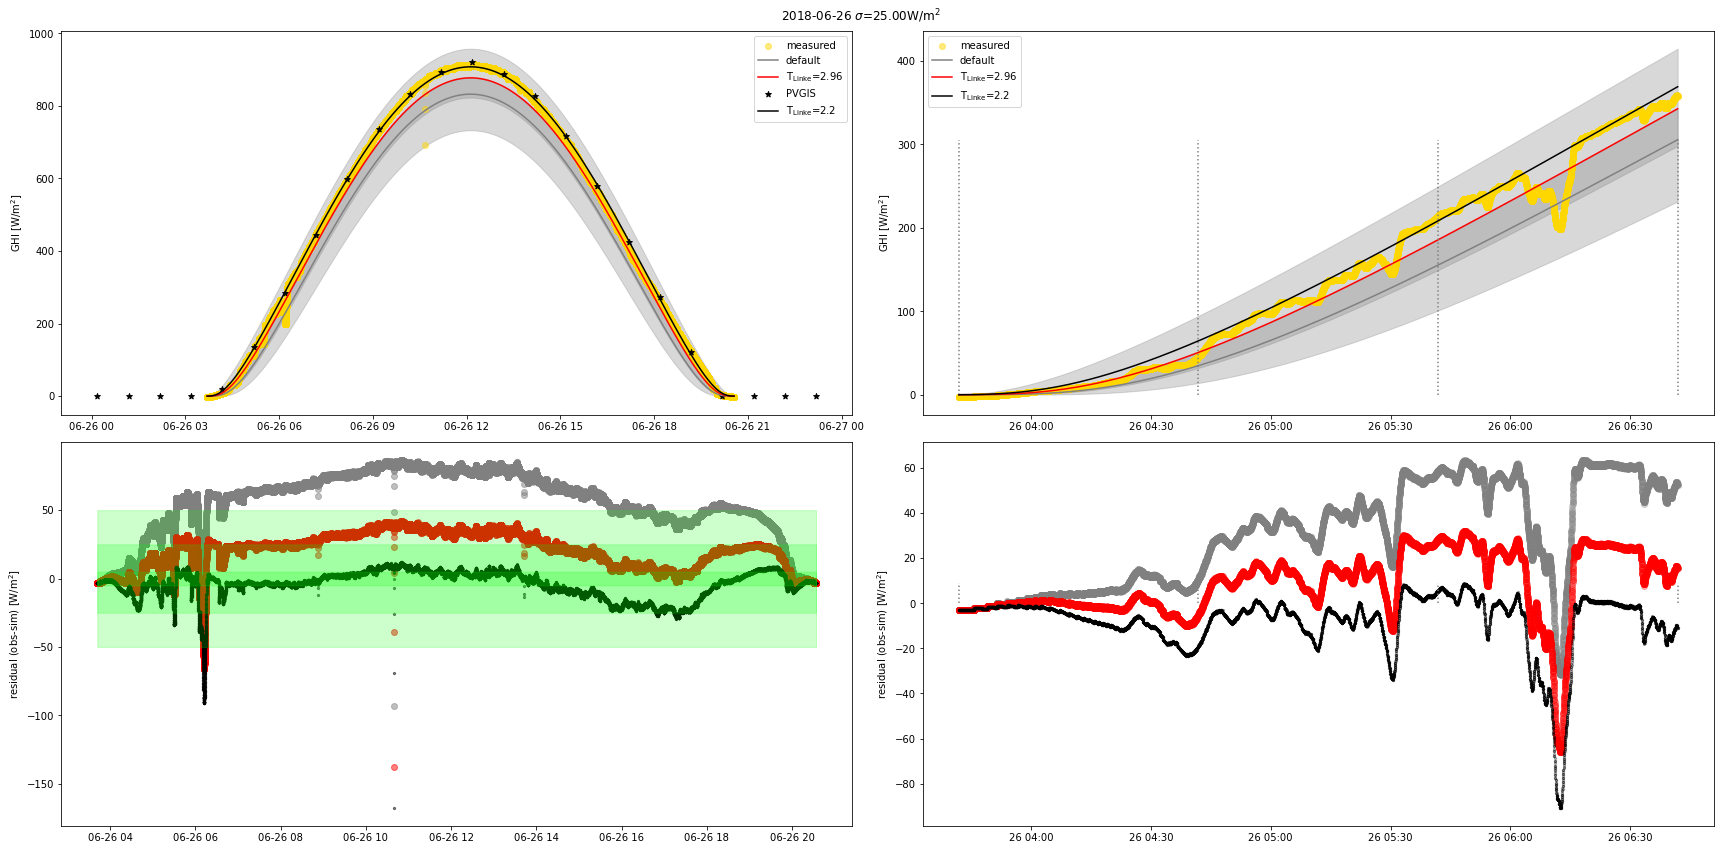

In [23]:
# make a pretty picture
ncols=2
nrows=2
fig,axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12*ncols,6*nrows))
fig.suptitle(f"{date} $\sigma$={sigma:.2f}W/m$^2$")

# from completely clear and dry to full on industrial
ax = axs[0,0]
ax.set_ylabel("GHI [W/m$^2$]")
best = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=1)
worst = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=7)
ax.fill_between(best.index, y1=worst['ghi'], y2=best['ghi'], color='grey', alpha=0.3)
ax = axs[0,1]
ax.set_ylabel("GHI [W/m$^2$]")
best_clip = best.between_time(start_time=start, end_time=end)
worst_clip = worst.between_time(start_time=start, end_time=end)
ax.fill_between(best_clip.index, y1=worst_clip['ghi'], y2=best_clip['ghi'], color='grey', alpha=0.3)

ax = axs[0,0]
# from pvlib satellite values for the location
best = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=2.95)
worst = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=4.4)
ax.fill_between(best.index, y1=worst['ghi'], y2=best['ghi'], color='grey', alpha=0.3)
ax.scatter(obs.index, obs['GHI [W/m2]'], label='measured', alpha=0.5, color='gold')
ax = axs[0,1]
best_clip = best.between_time(start_time=start, end_time=end)
worst_clip = worst.between_time(start_time=start, end_time=end)
ax.fill_between(best_clip.index, y1=worst_clip['ghi'], y2=best_clip['ghi'], color='grey', alpha=0.3)
ax.scatter(obs_clip.index, obs_clip['GHI [W/m2]'], label='measured', alpha=0.5, color='gold')

ax = axs[0,0]
default = location.get_clearsky(obs.index, model='ineichen')
t = func(cp_obs, *popt)
better = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=t)
ax.plot(default.index, default['ghi'], label='default', color='grey')
ax.plot(better.index, better['ghi'], label=f'T$_\mathrm{{Linke}}$={t:.2f}', color='r')
PVGIS = readPVGIS()
doy=obs.index[0].dayofyear-1
ax.scatter(PVGIS.index[doy*24:doy*24+24], PVGIS['Gb(i)'][doy*24:doy*24+24]+PVGIS['Gd(i)'][doy*24:doy*24+24]+PVGIS['Gr(i)'][doy*24:doy*24+24], marker="*", color='k', label='PVGIS')
pvgis = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=t_pvgis)
ax.plot(pvgis.index, pvgis['ghi'], label=f'T$_\mathrm{{Linke}}$={t_pvgis}', color='k')
ax.legend(loc="best")

ax = axs[0,1]
default_clip = default.between_time(start_time=start, end_time=end)
better_clip = better.between_time(start_time=start, end_time=end)
ax.plot(default_clip.index, default_clip['ghi'], label='default', color='grey')
ax.plot(better_clip.index, better_clip['ghi'], label=f'T$_\mathrm{{Linke}}$={t:.2f}', color='r')
for i in range(hours+1):
    ax.vlines(x=default_clip.index[i*3600], ymin=0, ymax=default_clip['ghi'].max(), color='grey', linestyle=':')
pvgis_clip = location.get_clearsky(default_clip.index, model='ineichen', linke_turbidity=t_pvgis)
ax.plot(pvgis_clip.index, pvgis_clip['ghi'], label=f'T$_\mathrm{{Linke}}$={t_pvgis}', color='k')
ax.legend(loc="upper left")

ax=axs[1,0]
ax.set_ylabel("residual (obs-sim) [W/m$^2$]")
residuals = obs['GHI [W/m2]']-default['ghi']
residuals_default = residuals.sum()
ax.scatter(obs.index, residuals, label='cf default', alpha=0.5, color='grey')
residuals = obs['GHI [W/m2]']-better['ghi']
residuals_better = residuals.sum()
ax.scatter(obs.index, residuals, label=f'cf T$_\mathrm{{Linke}}$={t:.2f}', alpha=0.5, color='r')
residuals = obs['GHI [W/m2]']-pvgis['ghi']
residuals_pvgis = residuals.sum()
ax.scatter(obs.index, residuals, label=f'cf T$_\mathrm{{Linke}}$={t_pvgis}', s=5, alpha=0.5, color='k')
print(residuals_default, residuals_better, residuals_pvgis)
ax.fill_between(obs.index, y1=-5, y2=5, color='lime', alpha=0.2, zorder=1)
ax.fill_between(obs.index, y1=-25, y2=25, color='lime', alpha=0.2, zorder=1)
ax.fill_between(obs.index, y1=-50, y2=50, color='lime', alpha=0.2, zorder=1)

ax=axs[1,1]
ax.set_ylabel("residual (obs-sim) [W/m$^2$]")
residuals = obs_clip['GHI [W/m2]']-default_clip['ghi']
residuals_default = residuals.sum()
ax.scatter(obs_clip.index, residuals, label='cf default', alpha=0.3, color='grey')
residuals = obs_clip['GHI [W/m2]']-better_clip['ghi']
residuals_better= residuals.sum()
ax.scatter(obs_clip.index, residuals, label=f'cf T$_\mathrm{{Linke}}$={t:.2f}', alpha=0.3, color='r')
residuals = obs_clip['GHI [W/m2]']-pvgis_clip['ghi']
residuals_pvgis = residuals.sum()
ax.scatter(obs_clip.index, residuals, label=f'cf T$_\mathrm{{Linke}}$={t_pvgis}', s=5, alpha=0.3, color='k')
for i in range(hours+1):
    ax.vlines(x=obs_clip.index[i*3600], ymin=0, ymax=residuals.max(), color='grey', linestyle=':')
print(residuals_default, residuals_better, residuals_pvgis)

plt.tight_layout()
plt.savefig(f"FitTurbBB-{date}-{hours}h.png", facecolor='w')

Example for a year: Calculate
* Linke turbidity factors
* Change Points
* Insolation

* Loop 1: doy (1-365)
    * Loop 2: hour (1-3)
        * Loop 3: Linke turbidity factor (1-7)
            * calculate Bayesian blocks for model
             * fit model blocks
        * calculate Bayesian blocks for obs
        * find $T_L$ for observed number of blocks
        * calculate insolation for that model fit

In [81]:
sigma = 25
p0=0.01

YEAR=2018
suntimes = pd.read_csv(f'../Data/{YEAR}-SunRiseSetTimes.txt', index_col=0, sep=' ', header=None, names=['date', 'rise', 'set'], parse_dates=True)
print(suntimes.info())

from scipy.optimize import curve_fit

ydata = range(lt_min,lt_max+1)
def func(x, a,b,c):
    return a*x**2 + b*x + c

prefix=f"../Data"
WriteCP = open(f"{prefix}/{2018}-sigma-{sigma:.2f}-fits-cp.txt", "a")
WriteCP.write("date\tcp (1h)\tcp (2h)\tcp (3h)\n")
WriteCS = open(f"{prefix}/{2018}-sigma-{sigma:.2f}-fits-cp-cs.txt", "a")
WriteCS.write("date\tcp (1h)\tcp (2h)\tcp (3h)\n")
WriteTurbidity = open(f"{prefix}/{2018}-sigma-{sigma:.2f}-fits-turbidity.txt", "a")
WriteTurbidity.write("date\tltf (1h)\tltf (2h)\tltf (3h)\n")
WriteInsolation = open(f"{prefix}/{2018}-sigma-{sigma:.2f}-fits-insolation.txt", "a")
WriteInsolation.write("date\tins (obs)\tins (cs)\tins (def)\tins (1h fit)\tins (2h fit)\tins (3h fit)\n")
plt.ioff() # interactive mode is off, figure will not be automatically showed [let us hope it is saved though]
#for month in range(1,12+1):
for month in range(7,7):
    end = 30
    if month==1 or month == 3 or month == 5 or month == 7 or month==8 or month==10 or month==12:
        end+=1
    elif month==2:
        end=28
    end=3
    for day in range(1, end+1):
        date = f"{YEAR}-{month:02}-{day:02}"
        WriteCP.write(f"{date}\t")
        WriteCS.write(f"{date}\t")
        WriteTurbidity.write(f"{date}\t")
        WriteInsolation.write(f"{date}\t")
        obs = getOBS(date)
        
        sunrise,sunset = suntimes.iloc[times.index.get_loc(date)]
        #print(date, sunrise, sunset)
        sunrise = datetime.strptime(f"{date} {sunrise}", "%Y-%m-%d %H:%M:%S")
        sunset = datetime.strptime(f"{date} {sunset}", "%Y-%m-%d %H:%M:%S")
        print(sunrise, sunset, sunset-sunrise)
        start = sunrise
        start = start.time().isoformat() # auto is seconds %H:%M:%S format string\n",

        cs = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=1)
        default = location.get_clearsky(obs.index, model='ineichen')
        WriteInsolation.write(f"{obs['GHI [W/m2]'].sum()}\t{cs['ghi'].sum()}\t{default['ghi'].sum()}\t")# as in 1s steps already == simples
        for hours in range(1,3+1):
            end = sunrise + timedelta(hours=hours)
            end = end.time().isoformat()
            # print(start, end)
            obs_clip = getOBS(date).between_time(start_time=start, end_time=end)
            t = np.array(obs_clip.index.to_frame(index=None).index.to_series().values)
            obs_edges = bayesian_blocks(t, obs_clip['GHI [W/m2]'], sigma, fitness='measures', p0=p0)
            cp_obs = len(obs_edges)
            WriteCP.write(f"{cp_obs}\t")
            print("\t", hours, cp_obs)
            cp = []
            for lt in range(lt_min,lt_max+1):
                cs = location.get_clearsky(obs_clip.index, model='ineichen', linke_turbidity=lt)
                #t = np.array(cs.index.to_frame(index=None).index.to_series().values)
                edges = bayesian_blocks(t, cs['ghi'], sigma, fitness='measures', p0=p0)
                cp.append(len(edges))
                print(f"\t\t{lt}, {len(edges)}")
                if 1==lt:
                    WriteCS.write(f"{len(edges)}\t") # this determines the most number of change points a clear sky should have and whether the obs cp has therefore gone out of bounds...
            popt, pcov = curve_fit(func, cp, ydata)
            t = func(cp_obs, *popt)
            WriteTurbidity.write(f"{t}\t")
            cs = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=t)
            WriteInsolation.write(f"{cs['ghi'].sum()}\t")# as in 1s steps already == simples
        WriteCP.write(f"\n") # another day is done
        WriteCS.write(f"\n") # another day is done
        WriteTurbidity.write(f"\n")
        WriteInsolation.write(f"\n")
    #gc.collect()
WriteCP.close() # our work here is done
WriteCS.close() # our work here is done
WriteTurbidity.close()
WriteInsolation.close()
plt.ion() # interactive mode is back on



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-01 to 2018-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rise    365 non-null    object
 1   set     365 non-null    object
dtypes: object(2)
memory usage: 8.6+ KB
None
2018-07-01 03:44:50 2018-07-01 20:32:26 16:47:36
	 1 5
		1, 6
		2, 5
		3, 4
		4, 4
		5, 3
		6, 3
		7, 3
	 2 12
		1, 13
		2, 12
		3, 11
		4, 10
		5, 9
		6, 8
		7, 7
	 3 53
		1, 20
		2, 19
		3, 17
		4, 16
		5, 15
		6, 14
		7, 13
2018-07-02 03:45:34 2018-07-02 20:32:03 16:46:29
	 1 5
		1, 6
		2, 5
		3, 4
		4, 4
		5, 3
		6, 3
		7, 3
	 2 11
		1, 13
		2, 12
		3, 11
		4, 10
		5, 9
		6, 8
		7, 7
	 3 17
		1, 20
		2, 19
		3, 17
		4, 16
		5, 15
		6, 14
		7, 13
2018-07-03 03:46:21 2018-07-03 20:31:36 16:45:15
	 1 5
		1, 6
		2, 5
		3, 4
		4, 4
		5, 3
		6, 3
		7, 3
	 2 18
		1, 13
		2, 12
		3, 11
		4, 10
		5, 9
		6, 8
		7, 7
	 3 27
		1, 20
		2, 19
		3, 17
		4, 16
		5, 15
		6, 14
		7, 13
2018-08

KeyboardInterrupt: 

If you need to close the files, e.g. after a keyboard interrupt...

In [82]:
# if the loop crashes you can close the files
WriteCP.close() # our work here is done
WriteCS.close() # our work here is done
WriteTurbidity.close()
WriteInsolation.close()


# MAPE

Calculate Mean Absolute Percentage Error (MAPE)

$ 
    \mathrm{MAPE} = \frac{100}{N} \sum_t^N \left | \frac{\hat{G_t} - G_t}{G_t} \right |
$

for the pyranometer measurement forecasts

* Loop days of the year
* Loop Calculate the $T_L$ from sunrise to 1h, 2h, 3h later
* calculate MAPE from the day for
    * pvlib default
    * BB fit
    * meteonorm
    * aeronet
    * NB, only have PVGIS fits for clear sky days


In [6]:
timestamps = pd.date_range(start=f"2018-01-01", end=f"2018-12-31", freq='D') # of course it recognises D but not day...
turbidity = pd.DataFrame(pvlib.clearsky.lookup_linke_turbidity(timestamps, latitude=lat, longitude=lon, interp_turbidity=False), columns=['pvlib (default)'])
turbidity['pvlib (interpolated)'] = pvlib.clearsky.lookup_linke_turbidity(timestamps, latitude=lat, longitude=lon, interp_turbidity=True)
meteonorm = np.zeros(len(turbidity))
aeronet = np.zeros(len(turbidity))
#turbidity['meteonorm'] = meteonorm
for i,x in enumerate(turbidity['pvlib (default)']):
    if turbidity.index[i].month == 1:
        meteonorm[i] = 2.92
        aeronet[i] = 2.84
    elif turbidity.index[i].month == 2:
        meteonorm[i] = 2.98
        aeronet[i] = 2.72
    elif turbidity.index[i].month == 3:
        meteonorm[i] = 3.32
        aeronet[i] = 3.45
    elif turbidity.index[i].month == 4:
        meteonorm[i] = 3.55
        aeronet[i] = 3.99
    elif turbidity.index[i].month == 5:
        meteonorm[i] = 3.56
        aeronet[i] = 3.95
    elif turbidity.index[i].month == 6:
        meteonorm[i] = 3.42
        aeronet[i] = 3.64
    elif turbidity.index[i].month == 7:
        meteonorm[i] = 3.28
        aeronet[i] = 3.51
    elif turbidity.index[i].month == 8:
        meteonorm[i] = 3.19
        aeronet[i] = 3.36
    elif turbidity.index[i].month == 9:
        meteonorm[i] = 3.1
        aeronet[i] = 3.67
    elif turbidity.index[i].month == 10:
        meteonorm[i] = 3.02
        aeronet[i] = 3.25
    elif turbidity.index[i].month == 11:
        meteonorm[i] = 2.88
        aeronet[i] = 2.7
    elif turbidity.index[i].month == 12:
        meteonorm[i] = 2.88
        aeronet[i] = 2.98
        #turbidity.at[i,'meteonorm'] = 2.92
turbidity['meteonorm'] = meteonorm
turbidity['aeronet'] = aeronet
print(turbidity)

            pvlib (default)  pvlib (interpolated)  meteonorm  aeronet
2018-01-01             2.95                  2.95       2.92     2.84
2018-01-02             2.95                  2.95       2.92     2.84
2018-01-03             2.95                  2.95       2.92     2.84
2018-01-04             2.95                  2.95       2.92     2.84
2018-01-05             2.95                  2.95       2.92     2.84
...                     ...                   ...        ...      ...
2018-12-27             2.95                  2.95       2.88     2.98
2018-12-28             2.95                  2.95       2.88     2.98
2018-12-29             2.95                  2.95       2.88     2.98
2018-12-30             2.95                  2.95       2.88     2.98
2018-12-31             2.95                  2.95       2.88     2.98

[365 rows x 4 columns]


In [22]:
WriteMAPE.close()

In [24]:
sigma = 25
p0=0.01

YEAR=2018
suntimes = pd.read_csv(f'../Data/{YEAR}-SunRiseSetTimes.txt', index_col=0, sep=' ', header=None, names=['date', 'rise', 'set'], parse_dates=True)
print(suntimes.info())

from scipy.optimize import curve_fit

ydata = range(lt_min,lt_max+1)
def func(x, a,b,c):
    return a*x**2 + b*x + c

def MAPE(sim, obs):
    residuals = (sim['ghi']-obs['GHI [W/m2]'])/(obs['GHI [W/m2]'])
    N = len(residuals)
    #print(residuals.sum())
    residuals = np.abs(residuals)
    #print(f"pvlib (def.): {(100/N)*residuals.sum():.2f}")
    return (100/N)*residuals.sum()

hours=3
prefix=f"../Data"
WriteMAPE = open(f"{prefix}/{2018}-sigma-{sigma:.2f}-fits-mape.txt", "a")
WriteMAPE.write("date\tpvlib\tmeteonorm\taeronet")
for h in range(1,hours+1):
    WriteMAPE.write(f"\tBB ({h}h)")
WriteMAPE.write("\n")
plt.ioff() # interactive mode is off, figure will not be automatically showed [let us hope it is saved though]
#for month in range(1,12+1):
for month in range(1,12+1):
    end = 30
    if month==1 or month == 3 or month == 5 or month == 7 or month==8 or month==10 or month==12:
        end+=1
    elif month==2:
        end=28
    for day in range(1, end+1):
        date = f"{YEAR}-{month:02}-{day:02}"
        WriteMAPE.write(f"{date}")
        
        obs = getOBS(date) # this gets us a day's measurements between sunrise and sunset
        # should I fit BB to the full day given I know the MAPE will explode on intermittent days?
        cs = location.get_clearsky(obs.index, model='ineichen')
        mape_pvlib = MAPE(cs, obs)
        WriteMAPE.write(f"\t{mape_pvlib:.2f}")

        #sunrise,sunset = suntimes.iloc[obs.index.get_loc(date)]
        ##print(date, sunrise, sunset)
        #sunrise = datetime.strptime(f"{date} {sunrise}", "%Y-%m-%d %H:%M:%S")
        #sunset = datetime.strptime(f"{date} {sunset}", "%Y-%m-%d %H:%M:%S")
        #print(sunrise, sunset, sunset-sunrise)
        #start = sunrise
        #start = start.time().isoformat() # auto is seconds %H:%M:%S format string\n",
        start = obs.index[0]

        # find the meteonorm turbidity value for this date
        doy=obs.index[0].dayofyear-1
        cs = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=turbidity['meteonorm'].iloc[doy])
        mape_meteo = MAPE(cs, obs)
        WriteMAPE.write(f"\t{mape_meteo:.2f}")
        cs = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=turbidity['aeronet'].iloc[doy])
        mape_aero = MAPE(cs, obs)
        WriteMAPE.write(f"\t{mape_aero:.2f}")
        #print(f"\t\t{mape_pvlib:.2f} {turbidity['meteonorm'].iloc[doy]} {mape_meteo:.2f} {turbidity['aeronet'].iloc[doy]} {mape_aero:.2f}")
        print(f"\t\t{mape_pvlib:.2f} {mape_meteo:.2f} {mape_aero:.2f}")
        for h in range(1,hours+1):
            #end = sunrise + timedelta(hours=h) # could I just do this from index[0]
            end = obs.index[0] + timedelta(hours=h) # could I just do this from index[0]
            #end = end.time().isoformat()
            # print(start, end)
            obs_clip = obs.between_time(start_time=start.time().isoformat(), end_time=end.time().isoformat())
            t = np.array(obs_clip.index.to_frame(index=None).index.to_series().values)
            obs_edges = bayesian_blocks(t, obs_clip['GHI [W/m2]'], sigma, fitness='measures', p0=p0)
            cp_obs = len(obs_edges)
            #print("\t", hours, cp_obs)
            cp = []
            for lt in range(lt_min,lt_max+1):
                cs = location.get_clearsky(obs_clip.index, model='ineichen', linke_turbidity=lt)
                #t = np.array(cs.index.to_frame(index=None).index.to_series().values)
                edges = bayesian_blocks(t, cs['ghi'], sigma, fitness='measures', p0=p0)
                cp.append(len(edges))
                #print(f"\t\t{lt}, {len(edges)}")
            popt, pcov = curve_fit(func, cp, ydata)
            t = func(cp_obs, *popt)
            mape_h = np.nan
            if t > 0:
                cs = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=t)
                mape_h = MAPE(cs, obs)
            WriteMAPE.write(f"\t{mape_h:.2f}")
            print(f"\t\t{h} {t:.2f} {mape_h:.2f}")
        WriteMAPE.write(f"\n") # another day is done
        WriteMAPE.flush()
    #gc.collect()
WriteMAPE.close() # our work here is done
plt.ion() # interactive mode is back on


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-01 to 2018-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rise    365 non-null    object
 1   set     365 non-null    object
dtypes: object(2)
memory usage: 8.6+ KB
None
	 2018-01-01 08:17:04 2018-01-01 16:00:11 7:43:07
		152.74 153.95 157.25
		1 7.82 80.90
		2 4.65 105.10
		3 3.79 124.32
	 2018-01-02 08:16:54 2018-01-02 16:01:18 7:44:24
		inf inf inf
		1 9.29 inf
		2 10.88 inf
		3 8.56 inf
	 2018-01-03 08:16:40 2018-01-03 16:02:28 7:45:48
		76.22 77.26 80.10
		1 7.82 46.65
		2 8.22 49.63
		3 3.79 52.26
	 2018-01-04 08:16:24 2018-01-04 16:03:40 7:47:16
		165.17 166.75 171.03
		1 7.82 48.81
		2 1.14 295.92
		3 -10.62 nan
	 2018-01-05 08:16:03 2018-01-05 16:04:55 7:48:52
		191.90 193.59 198.23
		1 4.00 143.81
		2 0.17 438.26
		3 -2.37 nan
	 2018-01-06 08:15:39 2018-01-06 16:06:13 7:50:34
		101.96 103.10 106.23
		1 7.82 42.02
		2 4.95 55.13
		3 -2.3

Do not run the following cells unless you know what you're doing

In [15]:
sigma = 5
p0=0.01

YEAR=2018
suntimes = pd.read_csv(f'../Data/{YEAR}-SunRiseSetTimes.txt', index_col=0, sep=' ', header=None, names=['date', 'rise', 'set'], parse_dates=True)
print(suntimes.info())

from scipy.optimize import curve_fit

ydata = range(lt_min,lt_max+1)
def func(x, a,b,c):
    return a*x**2 + b*x + c

prefix=f"../Data"
#for month in range(1,12+1):
date = f"2018-07-03"
obs = getOBS(date)

sunrise,sunset = suntimes.iloc[suntimes.index.get_loc(date)]
#print(date, sunrise, sunset)
sunrise = datetime.strptime(f"{date} {sunrise}", "%Y-%m-%d %H:%M:%S")
sunset = datetime.strptime(f"{date} {sunset}", "%Y-%m-%d %H:%M:%S")
print(sunrise, sunset, sunset-sunrise)
start = sunrise
start = start.time().isoformat() # auto is seconds %H:%M:%S format string\n",

cs = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=1)
default = location.get_clearsky(obs.index, model='ineichen')
for hours in range(1,17+1):
    end = sunrise + timedelta(hours=hours)
    end = end.time().isoformat()
    # print(start, end)
    obs_clip = getOBS(date).between_time(start_time=start, end_time=end)
    t = np.array(obs_clip.index.to_frame(index=None).index.to_series().values)
    obs_edges = bayesian_blocks(t, obs_clip['GHI [W/m2]'], sigma, fitness='measures', p0=p0)
    cp_obs = len(obs_edges)
    cp = []
    for lt in range(lt_min,lt_max+1):
        cs = location.get_clearsky(obs_clip.index, model='ineichen', linke_turbidity=lt)
        #t = np.array(cs.index.to_frame(index=None).index.to_series().values)
        edges = bayesian_blocks(t, cs['ghi'], sigma, fitness='measures', p0=p0)
        cp.append(len(edges))
        print(f"\t\t{lt}, {len(edges)}")
    popt, pcov = curve_fit(func, cp, ydata)
    t = func(cp_obs, *popt)
    cs = location.get_clearsky(obs.index, model='ineichen', linke_turbidity=t)
    print(date, sigma, hours, cp_obs, t)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-01 to 2018-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rise    365 non-null    object
 1   set     365 non-null    object
dtypes: object(2)
memory usage: 8.6+ KB
None
2018-07-03 03:46:21 2018-07-03 20:31:36 16:45:15
		1, 24
		2, 19
		3, 16
		4, 13
		5, 10
		6, 8
		7, 7
2018-07-03 5 1 20 1.7646795940305786
		1, 56
		2, 50
		3, 45
		4, 40
		5, 36
		6, 32
		7, 29
2018-07-03 5 2 84 -0.7947594436419791
		1, 89
		2, 83
		3, 77
		4, 71
		5, 66
		6, 62
		7, 57
2018-07-03 5 3 152 -2.8349866524669984
		1, 122
		2, 115
		3, 109
		4, 103
		5, 97
		6, 92
		7, 87
2018-07-03 5 4 212 -4.28219820811637
		1, 151
		2, 144
		3, 138
		4, 132
		5, 126
		6, 120
		7, 115
2018-07-03 5 5 246 -8.000727897090812
		1, 176
		2, 169
		3, 163
		4, 157
		5, 151
		6, 145
		7, 139
2018-07-03 5 6 458 -21.223888831761506
		1, 196
		2, 189
		3, 182
		4, 176
		5, 170
		6, 164
		7, 

C:\Users\mkdan\.conda\envs\crest\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


2018-07-03 5 14 1676 -282.3991034991025
		1, 367
		2, 358
		3, 351
		4, 343
		5, 334
		6, 326
		7, 317
2018-07-03 5 15 1707 -423.1322239049661
		1, 397
		2, 387
		3, 377
		4, 366
		5, 356
		6, 345
		7, 335
2018-07-03 5 16 1734 -187.8992915737876
		1, 412
		2, 398
		3, 385
		4, 372
		5, 360
		6, 348
		7, 338
2018-07-03 5 17 1745 207.0513143697038


In [45]:

clear = []
prefix = "./"
with open(f"{prefix}/clear.txt") as ReadMe:
    for line in ReadMe:
        date = line.strip()
        clear.append(date)
        #clear.append(line)
#clear=np.array(clear[:-1])
#clear=np.array(clear[:-1])
print(clear)
mixed = []
with open(f"{prefix}/mixed.txt") as ReadMe:
    for line in ReadMe:
        date = line.strip()
        mixed.append(date)
        #clear.append(line)
#mixed=np.array(mixed)
print(mixed)
overcast = []
with open(f"{prefix}/overcast.txt") as ReadMe:
    for line in ReadMe:
        date = line.strip()
        overcast.append(date)
        #clear.append(line)
#overcast=np.array(overcast)
print(overcast)

#for day in clear:
#sub = ins.loc(tuple(clear))
dfc = fins.loc[pd.to_datetime(clear)]
print(dfc)
dfm = fins.loc[pd.to_datetime(mixed)]
dfo = fins.loc[pd.to_datetime(overcast)]


['2018-02-25', '2018-04-05', '2018-05-05', '2018-05-06', '2018-05-14', '2018-05-15', '2018-05-20', '2018-06-22', '2018-06-25', '2018-06-26', '2018-06-28', '2018-06-30', '2018-07-02', '2018-07-03', '2018-07-15', '2018-09-01', '2018-09-25', '2018-09-29', '2018-10-09', '2018-11-13']
['2018-01-01', '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08', '2018-01-10', '2018-01-12', '2018-01-13', '2018-01-15', '2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-22', '2018-01-23', '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28', '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-04', '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09', '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13', '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21', '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01', '201